# **Spit some [tensor] flow**

We need to learn the intricacies of tensorflow to master deep learning

`Let's get this over with`



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
print(tf.__version__)

2.2.0


## Look at the following equations 

Well now we're going to go into the details of the implementation; 

```
x_pred_t = w0 + w1 * x_t-1 + w2 * x_t-2 + w3 * x_t-3 + w4 * x_t-4

x_pred_t+1 = w0 + w1 * x_pred_t + w2 * x_t-1 + w3 * x_t-2 + w4 * x_t-3
```

This is an autoregressive model now. 

```
x_pred_5 = w0 + w1 * x_4 + w2 * x_3 + w3 * x_2 + w4 * x_1

x_pred_6 = w0 + w1 * x_pred_5 + w2 * x_4 + w3 * x_3 + w4 * x_2

```

We know that the predictions at time T in an RNN depend on all the previous times. Thus, indirectly, y(t) depends on x(t), x(t-1), x(t-2),....., x(2), x(1)

To optimize the weights, we must take the derivative of the equation containing the weights; however, there will be numerous W_input_to_hidden weights in the network. 


The RNN keeps nesting the older timestamps; the derivatives use multiplication and chain rule in composite functions, thus, the more older the timestamp, the more its gradient vanishes.

## So how do GRU's work?

Throwback to the RNN equation: 

h(t) = activation(W(x,h) x(t) + W(h,h) h(t-1) + b(h))

GRU's calulate two other things to calculate h(t):

- update gate vector z(t)

- reset gate vector r(t)

z(t) = sigmoid(W(x,z) x(t) + W(h,z) h(t-1) + b(z))

r(t) = sigmoid(W(x,r) x(t) + W(h,r) h(t-1) + b(r))

```
h(t) = (1 - z(t)) * h(t-1)  +

        z(t) tanh(W(x,h) x(t) + W(h,h) (r(t) * h(t-1)) + b(h))
```

(*) ==== element wise multiplication

z(t), r(t), h(t) ===== Size U

## Z(t) 

Should we take the new value of h(t)? or keep h(t-1)? 

- z(t) close to 0, take h(t-1)

- z(t) close to 1, take h(t)

So: 

```
h(t) = (1 - z(t)) * h(t-1)  +

        z(t) tanh(W(x,h) x(t) + W(h,h) (r(t) * h(t-1)) + b(h))
```

Becomes 

```
h(t) = (factor keep h(t-1)) * h(t-1) + 

       (discard h(t-1)) * RNN(x(t), h(t-1))
```

## R(t) 

Change the value of h(t-1) 

- r(t) close to 0, zero value h(t-1)

- r(t) close to 1, keep value h(t-1)


## So how do LSTM's work?

### https://towardsdatascience.com/

We add another state to the mix, the cell state c(t)

we add three different neurons:

forget neuron = f(t) 

This gate decides which information should be thrown away or kept. Input from h(t-1) and x(t) is passed through this gate; and it uses sigmoid to either forget (0) or remember (1) it.


input gate neuron = i(t)

We use this to update the cell state. We pass the h(t-1) and x(t) to the sigmoid function. This will decide which values will be updated in the cell state.

output gate neuron = o(t) 

The output gate decides what the next hidden state h(t) should be. Remember that the hidden state contains information on previous inputs. The hidden state is also used for predictions. 

First, we pass the previous hidden state and the current input into a sigmoid function.

Then we pass the newly modified cell state to the tanh function. 

We multiply the tanh output with the sigmoid output to decide what information the hidden state should carry. 

The output is the hidden state. 

The new cell state and the new hidden is then carried over to the next time step.

```

f(t) = sigmoid ( W(x,f) x(t) + W(h, f)h(t-1) + b(f) )

i(t) = sigmoid ( W(x,i) x(t) + W(h, i)h(t-1) + b(i) ) 

o(t) = sigmoid ( W(x,o) x(t) + W(h, o)h(t-1) + b(o) ) 


c(t) = f(t) * c(t-1) + 

       i(t) * tanh ( W(x,c) x(t) + W(h,c) h(t-1) + b(c) ) 


h(t) = o(t) * tanh( c(t) )

```

## So we OHE the last NLP problem, why not do the same and feed it to the neural network? Well because, features in a language, are not independent. 


Let's explore this: 

The quick brown fox jumps over __________________

See you know the end of this sentence because you know the words right? 

well wb this: 

over _____________________

Now we don't know the end of this sentence. 

So in tensorflow, to save computations, we have the embedding layer: 

### Step 1: Words to ints

Nothing deep about deep learning ----> 13 43 32 43 98

### Step 2: Ints to word vector 

13 43 32 43 98 ------> [0.9, 1.2] [-0.4, 0.2] [0.3, 0.3] [-0.4, 0.2] [0.2, 0.5] 

T -----> T x D


### We can use word2vec to make sure the embedding layer has similar words close to each other


In [0]:
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, SimpleRNN, LSTM, GlobalMaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, Adamax
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Let's import the dataset


In [0]:
def evaluation_tf(report, y_test, y_pred, classes):
  plt.plot(report.history['loss'], label = 'training_loss')
  plt.plot(report.history['val_loss'], label = 'validation_loss')
  plt.legend()
  plt.show()
  plt.plot(report.history['accuracy'], label = 'training_accuracy')
  plt.plot(report.history['val_accuracy'], label = 'validation_accuracy')
  plt.legend()
  plt.show()

  from sklearn.metrics import confusion_matrix
  import itertools
  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(10,10))
  plt.imshow(cm, cmap=plt.cm.Blues)
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i,j], 'd'),
            horizontalalignment = 'center',
            color='black')
  plt.xlabel("Predicted labels")
  plt.ylabel("True labels")
  plt.xticks(range(0,classes))
  plt.yticks(range(0,classes))
  plt.title('Confusion matrix')
  plt.colorbar()
  plt.show()

In [12]:
data = pd.read_csv("sample_data/train.tsv", delimiter='\t')
data.head()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [13]:
Y = len(data.Sentiment.unique())
print(Y)

5


In [0]:
X = data.iloc[:, 2]
y = data.iloc[:, -1].values

In [0]:
# TRAIN TEST SPLIT
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [0]:
MAX_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)


In [17]:
word2index = tokenizer.word_index
V = len(word2index)
print("tokens = " + str(V))

tokens = 15270


In [0]:
X_train = pad_sequences(sequences_train)

In [0]:
X_test = pad_sequences(sequences_test, maxlen=X_train.shape[1])

In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

N, T = X_train.shape

(124848, 49)
(31212, 49)
(124848,)
(31212,)


In [0]:
# Let's talk about D, what is it and how do we set it? 
# This is the dimensionality of the embedding layer, essentially the vector that each word becomes 

D = 10 
# hidden units
U = 20


In [0]:
i_layer = Input(shape = (T,))
h_layer = Embedding(V+1, D)(i_layer)
# V+1 because https://github.com/tensorflow/tensorflow/issues/38619
h_layer = LSTM(U,return_sequences=True)(h_layer)
h_layer = GlobalMaxPooling1D()(h_layer)
o_layer = Dense(Y, activation='softmax')(h_layer)

model = Model(i_layer, o_layer)

In [0]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [26]:
report = model.fit(X_train, y_train, epochs = 20, validation_data=(X_test, y_test))

Epoch 1/20
3902/3902 [==============================] - 28s 7ms/step - loss: 1.1607 - accuracy: 0.5403 - val_loss: 1.0141 - val_accuracy: 0.5921
Epoch 2/20
3902/3902 [==============================] - 28s 7ms/step - loss: 0.8765 - accuracy: 0.6462 - val_loss: 0.8574 - val_accuracy: 0.6496
Epoch 3/20
3902/3902 [==============================] - 28s 7ms/step - loss: 0.7807 - accuracy: 0.6803 - val_loss: 0.8312 - val_accuracy: 0.6626
Epoch 4/20
3902/3902 [==============================] - 28s 7ms/step - loss: 0.7334 - accuracy: 0.6983 - val_loss: 0.8164 - val_accuracy: 0.6701
Epoch 5/20
3902/3902 [==============================] - 28s 7ms/step - loss: 0.6985 - accuracy: 0.7128 - val_loss: 0.8145 - val_accuracy: 0.6703
Epoch 6/20
3902/3902 [==============================] - 28s 7ms/step - loss: 0.6707 - accuracy: 0.7242 - val_loss: 0.8211 - val_accuracy: 0.6689
Epoch 7/20
3902/3902 [==============================] - 29s 7ms/step - loss: 0.6469 - accuracy: 0.7344 - val_loss: 0.8277 - val_ac

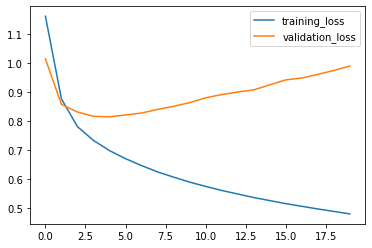

In [27]:
plt.plot(report.history['loss'], label='training_loss')
plt.plot(report.history['val_loss'], label='validation_loss')
plt.legend()

## Seems like the model is overfitting, let's tune it

In [0]:
# Let's talk about D, what is it and how do we set it? 
# This is the dimensionality of the embedding layer, essentially the vector that each word becomes 

D = 15
# hidden units
U = 30


In [0]:
i_layer = Input(shape = (T,))
h_layer = Embedding(V+1, D)(i_layer)
# V+1 because https://github.com/tensorflow/tensorflow/issues/38619

h_layer = LSTM(U,return_sequences=True)(h_layer)
h_layer = GlobalMaxPooling1D()(h_layer)
h_layer = Dense(5, activation='relu')(h_layer)
h_layer = Dropout(0.3)(h_layer)
o_layer = Dense(Y, activation='softmax')(h_layer)

model = Model(i_layer, o_layer)

In [0]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [93]:
report = model.fit(X_train, y_train, epochs = 10, validation_data=(X_test, y_test))

Epoch 1/10
3902/3902 [==============================] - 31s 8ms/step - loss: 1.1781 - accuracy: 0.5279 - val_loss: 1.0957 - val_accuracy: 0.5421
Epoch 2/10
3902/3902 [==============================] - 31s 8ms/step - loss: 1.0955 - accuracy: 0.5518 - val_loss: 1.0789 - val_accuracy: 0.5565
Epoch 3/10
3902/3902 [==============================] - 31s 8ms/step - loss: 1.0683 - accuracy: 0.5555 - val_loss: 1.0723 - val_accuracy: 0.5551
Epoch 4/10
3902/3902 [==============================] - 31s 8ms/step - loss: 1.0416 - accuracy: 0.5587 - val_loss: 1.0673 - val_accuracy: 0.5588
Epoch 5/10
3902/3902 [==============================] - 31s 8ms/step - loss: 0.9975 - accuracy: 0.5733 - val_loss: 0.9965 - val_accuracy: 0.6119
Epoch 6/10
3902/3902 [==============================] - 31s 8ms/step - loss: 0.9157 - accuracy: 0.6253 - val_loss: 0.9387 - val_accuracy: 0.6368
Epoch 7/10
3902/3902 [==============================] - 32s 8ms/step - loss: 0.8761 - accuracy: 0.6441 - val_loss: 0.9158 - val_ac

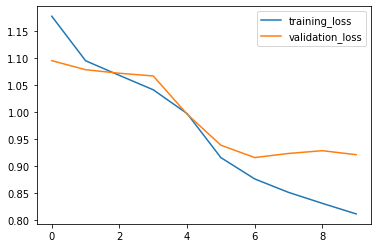

In [95]:
plt.plot(report.history['loss'], label='training_loss')
plt.plot(report.history['val_loss'], label='validation_loss')
plt.legend()

In [96]:
print(X_train.shape)
print(X_test.shape)

(124848, 49)
(31212, 49)


In [0]:
y_pred = model.predict(X_test).argmax(axis=1)

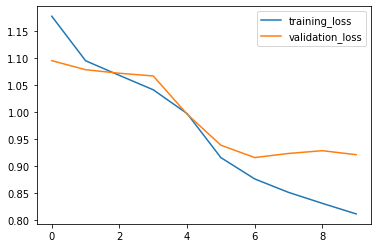

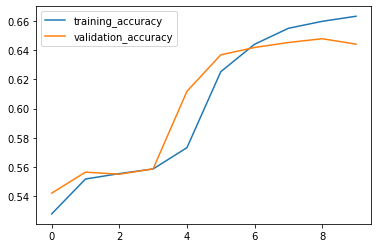

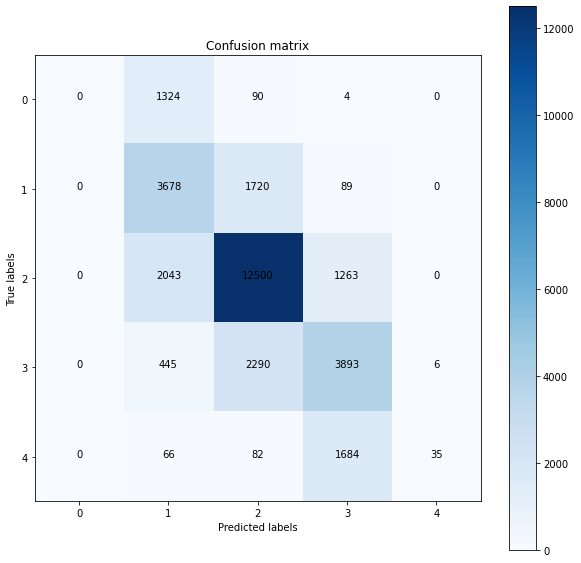

In [103]:
evaluation_tf(report, y_test, y_pred, Y)